### Importing required python modules:

In [3]:
# pip install pysolar

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import requests
from pysolar.solar import *
import datetime
import pytz
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,\
                                AutoMinorLocator
import seaborn as sns
import folium
import folium.plugins
%matplotlib inline


# Extracting and Cleaning Data:

In [5]:
df = pd.read_csv('Real-time_traffic_incident_Reports.csv')
df.info()

#df[df['Status']!='ARCHIVED']['Status'].shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133304 entries, 0 to 133303
Data columns (total 9 columns):
Traffic Report ID    133304 non-null object
Published Date       133304 non-null object
Issue Reported       133304 non-null object
Location             132948 non-null object
Latitude             133225 non-null float64
Longitude            133225 non-null float64
Address              133304 non-null object
Status               131611 non-null object
Status Date          133304 non-null object
dtypes: float64(2), object(7)
memory usage: 9.2+ MB


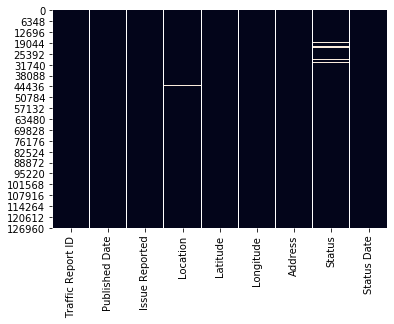

In [6]:
sns.heatmap(df.isnull(), cbar=False) #check for missing data


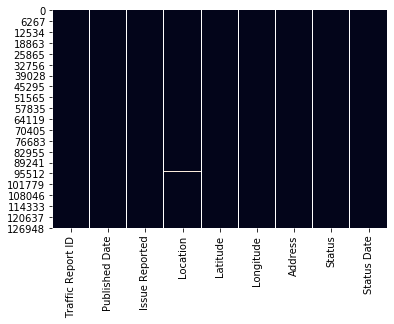

In [7]:
df = df[df['Status'] == 'ARCHIVED']  # We saved the archived entries only
sns.heatmap(df.isnull(), cbar=False)  # check for missing data

In [8]:
# There are some missing values for Location, Longitude and Latitudes.

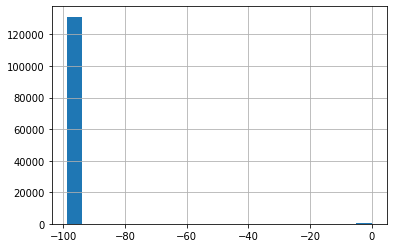

In [9]:
df['Longitude'].hist(bins=20)  # check the data points in the longitude.

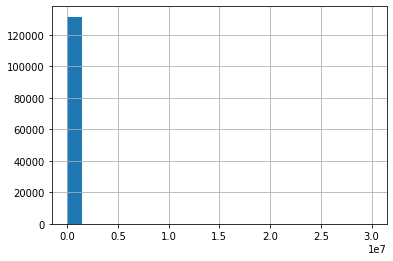

In [10]:
df['Latitude'].hist(bins=20)  # check the data points in the latitude.

Few data points are completely outside the geography outside the austin city and are due to error. The points that are too far from the Austin city will be omitted in the following few lines.  

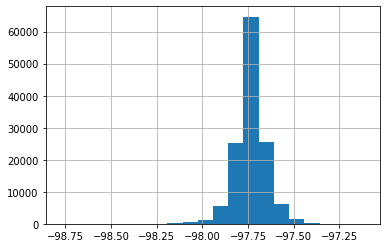

In [11]:
# Keep only the physically resonable latitude
df = df[(df['Latitude'] < 100) & (df['Longitude'] < -90)]
df['Longitude'].hist(bins=20)

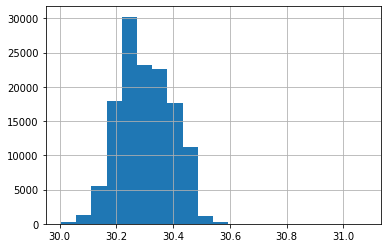

In [12]:
df['Latitude'].hist(bins=20)

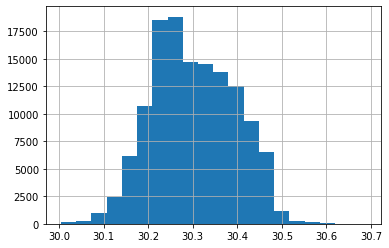

In [13]:
df = df[(df['Latitude'] < 30.7)]
# Keep only physically appropriate Longitudes.
df = df[(df['Longitude'] > -98.2) & (df['Longitude'] < -97.2)]
df['Latitude'].hist(bins=20)

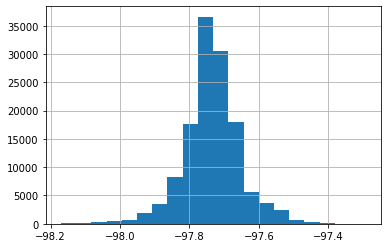

In [14]:
df['Longitude'].hist(bins=20)

In [15]:
df['Issue Reported'].unique()

array(['Crash Urgent', 'Crash Service', 'COLLISION/PRIVATE PROPERTY',
       'Traffic Hazard', 'Traffic Impediment', 'zSTALLED VEHICLE',
       'COLLISION', 'TRFC HAZD/ DEBRIS', 'COLLISION WITH INJURY',
       'BOAT ACCIDENT', 'COLLISN/ LVNG SCN', 'LOOSE LIVESTOCK',
       'VEHICLE FIRE', 'BLOCKED DRIV/ HWY', 'FLEET ACC/ INJURY',
       'ICY ROADWAY', 'AUTO/ PED', 'COLLISN / FTSRA', 'TRAFFIC FATALITY',
       'N / HZRD TRFC VIOL', 'HIGH WATER', 'FLEET ACC/ FATAL'],
      dtype=object)

In [16]:
cols = ['VEHICLE FIRE', 'Crash Urgent', 'Crash Service',
        'COLLISION/PRIVATE PROPERTY', 'COLLISION',
        'COLLISION WITH INJURY', 'COLLISN/ LVNG SCN',
        'FLEET ACC/ INJURY', 'COLLISN / FTSRA',
        'TRAFFIC FATALITY', 'FLEET ACC/ FATAL']

In [17]:
# dd = df['Published Date'].str.slice(start=0,stop=22)
df['pub_date1'] = pd.to_datetime(
    df['Published Date'].str.slice(start=0, stop=22),
    format='%m/%d/%Y  %I:%M:%S %p')
df['pub_date'] = pd.to_datetime(
    df['pub_date1'].map(lambda x: x.strftime('%Y-%m-%d %H')))
df['year'] = df['pub_date1'].dt.year
df['day'] = df['pub_date1'].dt.day
df['hour'] = df['pub_date1'].dt.hour
df['month'] = df['pub_date1'].dt.month
df['DayOfYear'] = df['pub_date1'].dt.dayofyear
df['DayOfWeek'] = df['pub_date1'].dt.dayofweek

In [18]:
df['Accident'] = pd.get_dummies(
    df['Issue Reported'])[cols].sum(axis=1,
                                    skipna=True)
df.head()

,Traffic Report ID,Published Date,Issue Reported,Location,Latitude,Longitude,Address,Status,Status Date,pub_date1,pub_date,year,day,hour,month,DayOfYear,DayOfWeek,Accident
0,8D4F80DF0D37819CDE3E3D2BB9982D111EBAC97C_15109...,11/17/2017 02:41:00 PM +0000,Crash Urgent,"(30.213998,-97.830319)",30.213998,-97.830319,6900 BRODIE LN,ARCHIVED,11/17/2017 03:25:00 PM +0000,2017-11-17 14:41:00,2017-11-17 14:00:00,2017,17,14,11,321,4,1
1,C163BCD1CF90C984E9EDA4DBA311BCA369A7D1A1_15288...,06/13/2018 06:35:59 AM +0000,Crash Service,"(30.283797,-97.741906)",30.283797,-97.741906,W 21ST ST & GUADALUPE ST,ARCHIVED,06/13/2018 09:00:03 AM +0000,2018-06-13 06:35:59,2018-06-13 06:00:00,2018,13,6,6,164,2,1
2,D5FCF8658503592FD19A3CEBD753CD5684DA5D9B_15109...,11/17/2017 03:08:00 PM +0000,COLLISION/PRIVATE PROPERTY,"(30.231041,-97.819314)",30.231041,-97.819314,5207 Brodie Ln,ARCHIVED,11/17/2017 03:30:00 PM +0000,2017-11-17 15:08:00,2017-11-17 15:00:00,2017,17,15,11,321,4,1
3,6B4142E2E97B851A319B0FCAB23709B40E3FC19F_15109...,11/17/2017 02:32:00 PM +0000,Traffic Hazard,"(30.338717,-97.739173)",30.338717,-97.739173,Burnet Ln & Burnet Rd,ARCHIVED,11/17/2017 03:30:00 PM +0000,2017-11-17 14:32:00,2017-11-17 14:00:00,2017,17,14,11,321,4,0
4,04B69E5006D308A60F286C6D87138324D3C745C6_15109...,11/17/2017 02:56:00 PM +0000,Traffic Hazard,"(30.38708,-97.743704)",30.387080,-97.743704,Mopac Nb To Research Nb Ramp & Research Blvd Nb,ARCHIVED,11/17/2017 03:35:00 PM +0000,2017-11-17 14:56:00,2017-11-17 14:00:00,2017,17,14,11,321,4,0


In [19]:
df.insert(loc=0, column='numbers', value=np.arange(len(df)))

In [20]:
col_drop = ['Traffic Report ID', 'Published Date', 'Location',
            'Address', 'Status', 'Status Date']
df_reduced = df.set_index('numbers').drop(columns=col_drop)
df_reduced.head()

,Issue Reported,Latitude,Longitude,pub_date1,pub_date,year,day,hour,month,DayOfYear,DayOfWeek,Accident
numbers,,,,,,,,,,,,
0,Crash Urgent,30.213998,-97.830319,2017-11-17 14:41:00,2017-11-17 14:00:00,2017,17,14,11,321,4,1
1,Crash Service,30.283797,-97.741906,2018-06-13 06:35:59,2018-06-13 06:00:00,2018,13,6,6,164,2,1
2,COLLISION/PRIVATE PROPERTY,30.231041,-97.819314,2017-11-17 15:08:00,2017-11-17 15:00:00,2017,17,15,11,321,4,1
3,Traffic Hazard,30.338717,-97.739173,2017-11-17 14:32:00,2017-11-17 14:00:00,2017,17,14,11,321,4,0
4,Traffic Hazard,30.387080,-97.743704,2017-11-17 14:56:00,2017-11-17 14:00:00,2017,17,14,11,321,4,0


In [21]:
# pd.get_dummies(df_reduced[df_reduced['Accident']==1]['DayOfWeek']).sum().plot(marker='o', markersize=10)

In [22]:
pd.get_dummies(df['Issue Reported']).sum()

AUTO/ PED                        22
BLOCKED DRIV/ HWY               209
BOAT ACCIDENT                    32
COLLISION                      9592
COLLISION WITH INJURY          3011
COLLISION/PRIVATE PROPERTY      519
COLLISN / FTSRA                   1
COLLISN/ LVNG SCN              2014
Crash Service                 22504
Crash Urgent                  30433
FLEET ACC/ FATAL                  1
FLEET ACC/ INJURY                17
HIGH WATER                        1
ICY ROADWAY                      25
LOOSE LIVESTOCK                2896
N / HZRD TRFC VIOL                3
TRAFFIC FATALITY                 19
TRFC HAZD/ DEBRIS              8184
Traffic Hazard                39435
Traffic Impediment             6100
VEHICLE FIRE                    322
zSTALLED VEHICLE               5875
dtype: int64

In [23]:
# US federal holidays for the time interval
# 1996-2020 are collected from the Kaggle link
# as https://www.kaggle.com/gsnehaa21/federal-holidays-usa-19662020
holidays = pd.read_csv('usholidays.csv')
holidays = holidays[['Date', 'Holiday']]
holidays.Date = pd.to_datetime(holidays.Date)

In [24]:
df_reduced.rename(columns={'pub_date': 'Date'}, inplace=True)
holidays = holidays[(holidays.Date >= min(df_reduced.Date)) &
                    (holidays.Date <= max(df_reduced.Date))]
df_reduced['Date'] = pd.to_datetime(
    df_reduced['Date'].map(lambda x: x.strftime('%Y-%m-%d')))

In [25]:
data_holidays = pd.merge(df_reduced, holidays, how='outer', on='Date')
new_data = data_holidays.fillna(0)

In [26]:
new_data1 = new_data.drop(columns='pub_date1')

In [27]:
# pd.get_dummies(new_data.hour).sum().plot('bar')

In [28]:
# API_KEY='384228b42960efdede58ec8f8c7f41db'

In [29]:
# date = list(str((pd.Timestamp(x)-pd.Timestamp('1970-01-01'))//pd.Timedelta('1s')) for x in dateRange)

In [30]:
# This function will return the margins of coordinates for the
# Austin city traffic incident report.


def margins(df):
    dfl = max(df['Latitude'])
    dfm = min(df['Latitude'])
    dflx = max(df['Longitude'])
    dfln = min(df['Longitude'])
    dtn = min(pd.to_datetime(df['Date']))
    dtx = max(pd.to_datetime(df['Date']))
    return dfl, dfm, dflx, dfln, dtn, dtx

# This function will create and return the mesh-points
# representing the geographical locations, value of grids determines
# the number of locations.


def LocPoints(df, grids):
    a, b, c, d, start_date, end_date = margins(df)
    # print('a: ', a, 'b: ', b, 'c: ', c, 'd: ', d)
    # print(start_date, end_date)
    # end_date - start_date
    bb = b
    dd = d
    delb = (a-b) / grids
    deld = abs(c-d) / grids
    lats = [b]
    longs = [d]
    for i in range(grids+1):
        bb += delb
        dd += deld
        lats.append(round(bb, 5))
        longs.append(round(dd, 5))
    return lats, longs
    # print('lats : ', lats, '\nlongs: ', longs)



In [62]:
# Calculate the area inside the mesh created by nearest grids. 
meshpoints = LocPoints(new_data, 20)
lengthLong = (meshpoints[0][2] - meshpoints[0][1])* \
            (np.cos(3.14 * (meshpoints[0][1])/180.0) * 69.0)
lengthWidth = (meshpoints[1][2] - meshpoints[1][1]) * 69.0
print('Areal Resolution: %0.2f' %(lengthLong * lengthWidth), 'Sq-miles')

Areal Resolution: 6.17 Sq-miles


In [ ]:
lat1 = 30.17534
    long1 = -97.95083
    long2 = -97.40291
lat2 = 30.43142
    long1 = -97.95083
    long2 = -97.40291
lat3 = 30.6875
    long1 = -97.95083
    long2 = -97.40291


In [30]:
# Locations where we download the hourly weather data from darksky.net.
weath_locs = [(30.17534, -97.95083), (30.17534, -97.40291),
              (30.43142, -97.95083), (30.43142, -97.40291),
              (30.6875, -97.95083), (30.6875, -97.40291)]

In [31]:
# Date range we concerned converted to the epoch time.
a, b, c, d, start_date, end_date = margins(new_data)
dateRange = pd.date_range(start_date, periods=710)
date = list(str((pd.Timestamp(x) -
                 pd.Timestamp('1969-12-31 18:00:00')) // pd.Timedelta('1s'))
            for x in dateRange)

In [ ]:
# Weather data are extracted using request.get()
# from api.darksky.net for the hourly weather report.
# The nested dictionary will be unpacked as:
for k in range(len(dateRange)):  # loop for the time daily report
    r = requests.get('https://api.darksky.net/
                     forecast/'+API_KEY+'/30.6875, -97.40291, '+date[k]+'?
                     exclude=currently, daily, flags')
    # It gives the json type of data
    datafile = pd.DataFrame.from_dict(r.json()['hourly'])['data']
    # This 'datafile' is the list of dictionaries
    # The dataframe with indices can be obtained as:
    ddf = pd.concat([pd.DataFrame.from_dict(y,
                     orient='index') for y in datafile], axis=1, sort=False)
    ddft = ddf.transpose()
    # The time column will be converted to the datetime format and
    # adjusted the timezone for the local time of Austin.
    ddft['Time'] = pd.to_datetime(ddft['time'], unit='s') +
    pd.Timedelta('-06:00:00')
    ddfnew = ddft[['Time', 'temperature', 'dewPoint', 'icon',
                   'precipIntensity', 'visibility', 'humidity', 'windSpeed']]
    # The dataframes for all values of k are appended to get
    # the single file for a fixed location.
    if k == 0:
        datafiles = ddfnew
    else:
        datafiles = datafiles.append(ddfnew)
datafiles6 = datafiles.rename(columns={'precipIntensity': 'pcpt_mmph'})
# datafilesXX are changed for the XX location
datafiles6.shape


In [ ]:
# The datafiles are appended with two additional columns showing
# the specific location(latitude and longitude for all chosen six locations)
datafiles2['lat'] = pd.Series(30.17534)
datafiles2['long'] = pd.Series(-97.40291)
datafiles1['lat'] = pd.Series(30.17534)
datafiles1['long'] = pd.Series(-97.95083)
dfiles = datafiles1.append(datafiles2)
datafiles3['lat'] = pd.Series(30.43142)
datafiles3['long'] = pd.Series(-97.95083)
dfiles3 = dfiles.append(datafiles3)
datafiles4['lat'] = pd.Series(30.43142)
datafiles4['long'] = pd.Series(-97.40291)
dfiles4 = dfiles3.append(datafiles4)
datafiles5['lat'] = pd.Series(30.6875)
datafiles5['long'] = pd.Series(-97.95083)
dfiles5 = dfiles4.append(datafiles5)
datafiles6['lat'] = pd.Series(30.6875)
datafiles6['long'] = pd.Series(-97.40291)
dfiles6 = dfiles5.append(datafiles6).reset_index()
dfiles6.drop(columns='index', inplace=True)
dfiles6.head()
# dfiles6 contains the weather data required for our projects.

In [32]:
new_data.head()

,Issue Reported,Latitude,Longitude,pub_date1,Date,year,day,hour,month,DayOfYear,DayOfWeek,Accident,Holiday
0,Crash Urgent,30.213998,-97.830319,2017-11-17 14:41:00,2017-11-17,2017,17,14,11,321,4,1,0
1,COLLISION/PRIVATE PROPERTY,30.231041,-97.819314,2017-11-17 15:08:00,2017-11-17,2017,17,15,11,321,4,1,0
2,Traffic Hazard,30.338717,-97.739173,2017-11-17 14:32:00,2017-11-17,2017,17,14,11,321,4,0,0
3,Traffic Hazard,30.387080,-97.743704,2017-11-17 14:56:00,2017-11-17,2017,17,14,11,321,4,0,0
4,Traffic Impediment,30.271539,-97.753964,2017-11-17 14:39:00,2017-11-17,2017,17,14,11,321,4,0,0


In [33]:
# dfiles6.to_csv(r'weather_data.csv')
# This will export the weather data in csv format in the working directory

In [34]:
# Convert the latitude and longitude data with
# rounding to 5 decimals to match the location points
# and the previous columns for latitude and longitude are dropped.
new_data['Latitude'] = round(new_data.Latitude, 5)
new_data['Longitude'] = round(new_data.Longitude, 5)
# new_data2 = new_data.drop(['Latitude', 'Longitude'], axis=1)

In [35]:
# d_2=dfiles6
# import the weather data saved before.
d_2 = pd.read_csv('weather_data.csv')
d_2.drop(columns='Unnamed: 0', inplace=True)

In [36]:
d_1 = new_data
# Keep only accident related data
d_1 = d_1[d_1['Accident'] == 1].reset_index()
# This function will define the four nearest location
# points for the given longitude and latitude of trafic incident data


def neighbors(nodd, latt, longg, lat_min, long_min):
    # latt and longg are the point-series of created mesh
    xx0 = 0.0
    x0, y0 = nodd
    lx0 = lat_min
    ly0 = long_min
    for i in range(1, len(latt)):
        lx = latt[i]
        if ((x0 >= lx0) & (x0 <= lx)):
            for j in range(1, len(longg)):
                ly = longg[j]
                if ((y0 >= ly0) & (y0 <= ly)):
                    lxy = (lx0, ly0), (lx0, ly), (lx, ly0), (lx, ly)
                    # four nearest mesh points for given x0, y0
                    return lxy
                ly0 = ly
        lx0 = lx
# nodes = np.asarray(lls)
node = list(zip(d_1['Latitude'], d_1['Longitude']))  # series of x0,y0
node = np.asarray(node)
locn = []
a, b, c, d, start_date, end_date = margins(d_1)
lats, longs = LocPoints(d_1, 20)
for xx in node:
    nodes = np.asarray(neighbors(xx, lats, longs, b, d))
    dist2 = np.sum((xx - nodes) ** 2, axis=1)
    locn.append(nodes[np.argmin(dist2)])
    # This returns the coordinates with the minimum distance 'dist2'

In [37]:
# Every traffic incident entry will be assigned to a
# specific location, i.e. the closest mesh point.
d_1['Location'] = pd.DataFrame({'Location': locn})
d_1['Location'] = tuple(d_1['Location'])
d_1.drop(columns='index', inplace=True)

In [38]:
# Mesh points for weather data are broader and only six mesh points were chosen
latw = [25.0, 30.17534, 30.43142, 30.6875, 40.0]
longw = [-100.0, -97.95083, -97.40291, -90.0]
a0 = min(latw)
d0 = min(longw)
weath_locn = []
for xw in node:
    nodes = np.asarray(neighbors(xw, latw, longw, a0, d0))
    dist2 = np.sum((xw - nodes) ** 2, axis=1)
    weath_locn.append(tuple(nodes[np.argmin(dist2)]))

In [39]:
weathlocn = pd.DataFrame(weath_locn, columns=['lat', 'long'])
# it unpacks the tuple and set to different columns

In [40]:
d_1['Time'] = pd.to_datetime(d_1['pub_date1']).dt.floor('h')
# convert the string format of given time of traffic incident to the datetime format
# and then to the hourly format

In [41]:
d_1weath = pd.concat([d_1, weathlocn], axis=1)
# append the traffic incident data with the weather location mesh-points

In [42]:
# if the d_2 is read_csv(weather_data.csv) 
# then convert the string format of time to datetime as
d_2['Time'] = pd.to_datetime(d_2['Time'])
# else if d_2 is just dfiles6, this line can be disabled.

In [43]:
# d_2.drop(columns='Unnamed: 0',inplace=True)
d_2['long'] = round(d_2.long, 5)
d_2['lat'] = round(d_2.lat, 5)

In [44]:
d_with_weath = d_1weath.merge(d_2, on=['Time', 'lat', 'long'], how='inner')

columnTitles = ['Time', 'Date', 'year', 'month', 'day', 'hour',
                'DayOfWeek', 'DayOfYear', 'Holiday', 'Latitude',
                'Longitude', 'Location', 'icon', 'pcpt_mmph',
                'visibility', 'humidity', 'windSpeed', 'Issue Reported',
                'temperature', 'dewPoint', 'Accident']
# dropTitles = ['lat', 'long', 'pub_date1']

d_with_weath = d_with_weath.reindex(columns=columnTitles)
d_with_weath.head()

,Time,Date,year,month,day,hour,DayOfWeek,DayOfYear,Holiday,Latitude,...,Location,icon,pcpt_mmph,visibility,humidity,windSpeed,Issue Reported,temperature,dewPoint,Accident
0,2017-11-17 14:00:00,2017-11-17,2017,11,17,14,4,321,0,30.21400,...,"(30.22388, -97.8488)",partly-cloudy-day,0.0,9.997,0.61,6.35,Crash Urgent,81.96,67.03,1
1,2017-11-17 14:00:00,2017-11-17,2017,11,17,14,4,321,0,30.29543,...,"(30.29011, -97.76334)",partly-cloudy-day,0.0,9.997,0.61,6.35,Crash Service,81.96,67.03,1
2,2017-11-17 14:00:00,2017-11-17,2017,11,17,14,4,321,0,30.25837,...,"(30.257, -97.76334)",partly-cloudy-day,0.0,9.997,0.61,6.35,Crash Service,81.96,67.03,1
3,2017-11-17 14:00:00,2017-11-17,2017,11,17,14,4,321,0,30.21379,...,"(30.22388, -97.8488)",partly-cloudy-day,0.0,9.997,0.61,6.35,Crash Service,81.96,67.03,1
4,2017-11-17 14:00:00,2017-11-17,2017,11,17,14,4,321,0,30.26432,...,"(30.257, -97.76334)",partly-cloudy-day,0.0,9.997,0.61,6.35,Crash Service,81.96,67.03,1


In [46]:
signals = pd.read_csv('Traffic_Signals.csv')
# Reading downloaded datafile for the traffic signals in city of Austin.

In [47]:
# Assigning the total traffic signals nearby every place of traffic incidence.


def distance(x, y, x0, y0):
    dist = np.sqrt(((x - x0) * (x - x0)) + ((y - y0) * (y - y0)))
    return dist

latitude = signals['Latitude']
longitude = signals['Longitude']
latx0, longy0 = LocPoints(d_1, 20)
radius = max((latx0[1] - latx0[0]), abs(longy0[1] - longy0[0]))
clust_pos = []
points = []
for x0 in latx0:
    for y0 in longy0:
        position = distance(latitude, longitude, x0, y0)
        clust_pos.append(position[position < radius].count())
        points.append(tuple((x0, y0)))
        # print(x0, y0, radius, '\n', position[position < radius])
signal_data = pd.DataFrame({('Location'): points, 'Signals': clust_pos})

In [48]:
d_with_weath['Location'] = tuple(d_with_weath.Location)

In [49]:
# Merging the traffic-signal dataframe to the master datafile
d_ws = pd.merge(d_with_weath,signal_data,
                how='inner', on='Location') 

In [50]:
# Rename the 'icon' to the 'Weather' for weather condition
d_ws.rename({'icon':'Weather'}, axis=1, inplace=True)

In [51]:
# If want to save this datafile with number of traffic signals
# d_ws.to_csv(r'data_with_ws.csv') 

In [52]:
d_ws.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68420 entries, 0 to 68419
Data columns (total 22 columns):
Time              68420 non-null datetime64[ns]
Date              68420 non-null datetime64[ns]
year              68420 non-null int64
month             68420 non-null int64
day               68420 non-null int64
hour              68420 non-null int64
DayOfWeek         68420 non-null int64
DayOfYear         68420 non-null int64
Holiday           68420 non-null object
Latitude          68420 non-null float64
Longitude         68420 non-null float64
Location          68420 non-null object
Weather           68420 non-null object
pcpt_mmph         68182 non-null float64
visibility        68245 non-null float64
humidity          68396 non-null float64
windSpeed         68389 non-null float64
Issue Reported    68420 non-null object
temperature       68396 non-null float64
dewPoint          68420 non-null float64
Accident          68420 non-null int64
Signals           68420 non-null i

In [53]:
# get the solar inclination using hourly data for given locations:
central = pytz.timezone("US/Central")
utc = pytz.utc
# naive = datetime.datetime.strptime ("2001-2-3 10:11:12", "%Y-%m-%d %H:%M:%S")
# local_dt = local.localize(naive, is_dst=None)
# utc_dt = local_dt.astimezone(pytz.utc)
altitude = []
for i in range(len(d_ws)):
    # date = datetime.datetime(d_ws.year[i], d_ws.month[i], 
                               # d_ws.day[i], d_ws.hour[i], 0, 0, 0)
    date = central.localize(d_ws['Time'][i]).astimezone(utc)
    altitude.append(get_altitude(d_ws.Latitude[i], d_ws.Longitude[i], date))

/usr/local/lib/python3.7/site-packages/pysolar/solartime.py:112: UserWarning: I don't know about leap seconds after 2018
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


In [54]:
# Add column solar inclination with the angle calculated above.
d_ws['Solar_inclination'] = pd.DataFrame(altitude)

In [55]:
# Reading downloaded datafile containing schools and location in Austin.
schools = pd.read_csv('School_Zone_Beacons.csv')

In [56]:
# Counting the number of schools nearby every place of incidence.
latitude = schools['latitude']
longitude = schools['longitude']
latx0, longy0 = LocPoints(d_1, 20)
radius = max((latx0[1] - latx0[0]), abs(longy0[1] - longy0[0]))
clust_schs = []
point_schs = []
for x0 in latx0:
    for y0 in longy0:
        position = distance(latitude, longitude, x0, y0)
        clust_schs.append(position[position < radius].count())
        point_schs.append(tuple((x0, y0)))
        # print(x0, y0, radius, '\n', position[position < radius])
sch_data = pd.DataFrame({('Location'): point_schs, 'Schools': clust_schs})

In [57]:
# Merging the dataframe with stations and schools to the master datafile
d_wssolsch = pd.merge(d_ws,sch_data,how='inner', on='Location')

In [58]:
# Reading downloaded datafile containing historical_landmarks 
# at various locations in Austin.
landmarks = pd.read_csv('STRUCTURE_historical_landmarks.csv')

In [59]:
# Counting the number of historical landmarks nearby every place of incidence.
newcol = landmarks.the_geom.str.split('(', expand=True)[1].str.split(
                                      ' ', expand=True)
longitude = newcol[0].astype(float)
latitude = newcol[1].str.split(')', expand=True)[0].astype(float)
# longitude = landmarks['longitude']
latx0, longy0 = LocPoints(d_1, 20)
radius = max((latx0[1] - latx0[0]), abs(longy0[1] - longy0[0]))
clust_lmrks = []
point_lmrks = []
for x0 in latx0:
    for y0 in longy0:
        position = distance(latitude, longitude, x0, y0)
        clust_lmrks.append(position[position < radius].count())
        point_lmrks.append(tuple((x0, y0)))
        # print(x0, y0, radius, '\n', position[position < radius])
lmrks_data = pd.DataFrame({(
             'Location'): point_lmrks, 'Landmarks': clust_lmrks})

In [60]:
# Merging the dataframe with stations and historical
# landmarks to the master datafile
d_wssolschlmrks = pd.merge(d_wssolsch, lmrks_data, how='inner',
                           on='Location')
d_wssolschlmrks = d_wssolschlmrks.reindex(['Time', 'Date', 'year',
                                           'month', 'day', 'hour',
                                           'DayOfWeek', 'DayOfYear',
                                           'Holiday', 'Latitude',
                                           'Longitude', 'Location',
                                           'Weather', 'pcpt_mmph',
                                           'visibility', 'humidity',
                                           'windSpeed', 'Signals',
                                           'Schools', 'Landmarks',
                                           'Solar_inclination',
                                           'temperature', 'dewPoint',
                                           'Issue Reported',
                                           'Accident'], axis=1)
d_wssolschlmrks.columns

Index(['Time', 'Date', 'year', 'month', 'day', 'hour', 'DayOfWeek',
       'DayOfYear', 'Holiday', 'Latitude', 'Longitude', 'Location', 'Weather',
       'pcpt_mmph', 'visibility', 'humidity', 'windSpeed', 'Signals',
       'Schools', 'Landmarks', 'Solar_inclination', 'temperature', 'dewPoint',
       'Issue Reported', 'Accident'],
      dtype='object')

In [61]:
d_wssolschlmrks[(d_wssolschlmrks['pcpt_mmph'].isnull())]['Weather'].unique()

array(['clear-night', 'clear-day', 'partly-cloudy-day'], dtype=object)

In [62]:
# Since, all the instances with missing pcpt_mmph are with no rain
# from column 'Weather', we fill the missing values as 0 mmph.
d_wssolschlmrks['pcpt_mmph'] = d_wssolschlmrks['pcpt_mmph'].fillna(0.)

In [63]:
d_wssolschlmrks[(d_wssolschlmrks['visibility'].isnull())]['Weather'].unique()

array(['clear-day', 'clear-night', 'partly-cloudy-day'], dtype=object)

In [69]:
# The missing values for the visibility, humidity, 
# and windspeed are imputed as their
# past immediate values.
d_wssolschlmrks['visibility'] = \
                d_wssolschlmrks['visibility'].fillna(method='ffill')
d_wssolschlmrks['humidity'] = \
                d_wssolschlmrks['humidity'].fillna(method='ffill')
d_wssolschlmrks['windSpeed'] = \
                d_wssolschlmrks['windSpeed'].fillna(method='ffill')
d_wssolschlmrks['temperature'] = \
                d_wssolschlmrks['temperature'].fillna(method='ffill')

In [70]:
print('visibility', d_wssolschlmrks[
     (d_wssolschlmrks['visibility'].isnull())]['Weather'].unique())
print('humidity', d_wssolschlmrks[
     (d_wssolschlmrks['humidity'].isnull())]['Weather'].unique())
print('windSpeed', d_wssolschlmrks[
     (d_wssolschlmrks['windSpeed'].isnull())]['Weather'].unique())
print('temperature', d_wssolschlmrks[
     (d_wssolschlmrks['temperature'].isnull())]['Weather'].unique())

visibility []
humidity []
windSpeed []
temperature []


In [71]:
d_wssolschlmrks.drop(columns=(d_wssolschlmrks.columns[(
                     d_wssolschlmrks.columns.str.contains('Unnamed'))]),
                     inplace=True)

In [74]:
# export the data in csv format in the working directory.
d_wssolschlmrks.to_csv(r'data_with_WSigLmrkSol.csv')